In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import json

In [2]:
# Function for loading in the credits card datasets
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
    
# Function for loading in movies datasets
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [3]:
# Calling the functions
movies = load_tmdb_movies('/content/drive/MyDrive/tmdb_5000_movies.csv')
credits = load_tmdb_credits('/content/drive/MyDrive/tmdb_5000_credits.csv')

In [4]:
# Creating a copy of each data
credits_copy = credits.copy()
movies_copy = movies.copy()

In [5]:
# First five rows of movies datasets
movies_copy.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [6]:
# First five rows of the credits card datasets
credits_copy.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de..."
3,49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de..."
4,49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de..."


In [7]:
# Funtion to append each value of the same key ('name') together
def pipe_flatten_names(keywords):
    return ', '.join([x['name'] for x in keywords])

In [8]:
# Applying the function the respective json columns
movies_copy['production_companies'] = movies_copy['production_companies'].apply(pipe_flatten_names)

In [9]:
# Let's pick some numerical columns that may be significant
movies_copy = movies_copy[['production_companies', 'budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']]

In [10]:
movies_copy2 = movies_copy.copy().set_index('production_companies')
movies_copy2.head(10)

,budget,popularity,revenue,runtime,vote_average,vote_count
production_companies,,,,,,
"Ingenious Film Partners, Twentieth Century Fox Film Corporation, Dune Entertainment, Lightstorm Entertainment",237000000,150.437577,2787965087,162.0,7.2,11800
"Walt Disney Pictures, Jerry Bruckheimer Films, Second Mate Productions",300000000,139.082615,961000000,169.0,6.9,4500
"Columbia Pictures, Danjaq, B24",245000000,107.376788,880674609,148.0,6.3,4466
"Legendary Pictures, Warner Bros., DC Entertainment, Syncopy",250000000,112.312950,1084939099,165.0,7.6,9106
Walt Disney Pictures,260000000,43.926995,284139100,132.0,6.1,2124
"Columbia Pictures, Laura Ziskin Productions, Marvel Enterprises",258000000,115.699814,890871626,139.0,5.9,3576
"Walt Disney Pictures, Walt Disney Animation Studios",260000000,48.681969,591794936,100.0,7.4,3330
"Marvel Studios, Prime Focus, Revolution Sun Studios",280000000,134.279229,1405403694,141.0,7.3,6767
"Warner Bros., Heyday Films",250000000,98.885637,933959197,153.0,7.4,5293


 IMDB's weighted rating (wr) which is given as :
$$(\dfrac{v}{v+m}.R)+(\dfrac{m}{v+m}.C)$$

where,

    v is the number of votes for the movie = vote_count in the column
    m is the minimum votes required to be listed in the chart
    R is the average rating of the movie = vote_average in the column
    C is the mean vote across the whole report


We 'll obtain m and C

In [11]:
C= movies_copy2['vote_average'].mean()
m= movies_copy2['vote_count'].quantile(0.9)

In [12]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [13]:
# Calling the function
movies_copy2['weighted_rating'] = movies_copy2.apply(weighted_rating, axis=1)

In [14]:
# Checking for the null rows
movies_copy2.isnull().sum()

budget             0
popularity         0
revenue            0
runtime            2
vote_average       0
vote_count         0
weighted_rating    0
dtype: int64

In [15]:
# Dropping the two null rows
movies_copy2 = movies_copy2.dropna()
movies_copy2.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,weighted_rating
production_companies,,,,,,,
"Ingenious Film Partners, Twentieth Century Fox Film Corporation, Dune Entertainment, Lightstorm Entertainment",237000000,150.437577,2787965087,162.0,7.2,11800,7.050669
"Walt Disney Pictures, Jerry Bruckheimer Films, Second Mate Productions",300000000,139.082615,961000000,169.0,6.9,4500,6.665696
"Columbia Pictures, Danjaq, B24",245000000,107.376788,880674609,148.0,6.3,4466,6.239396
"Legendary Pictures, Warner Bros., DC Entertainment, Syncopy",250000000,112.312950,1084939099,165.0,7.6,9106,7.346721
Walt Disney Pictures,260000000,43.926995,284139100,132.0,6.1,2124,6.096368


## Clusters between the Major film studios and Independents showing the entire numerical data points

In [41]:
# Importing the necessary dependencies
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Choosing hyper-parameters
kmeans = KMeans(n_clusters = 2, max_iter=600, algorithm = 'auto')
# Fitting the data
kmeans.fit(movies_copy2)
# Making clustering predictions
pred = kmeans.predict(movies_copy2)

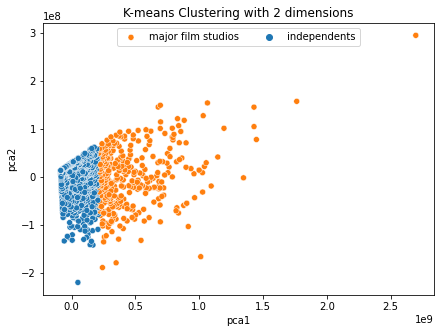

In [42]:
# To view the 2D clustering graph
# We'll import PCA and seaborn
from sklearn.decomposition import PCA
import seaborn as sns
# Fitting the data
reduced_data = PCA(n_components=2).fit_transform(movies_copy2)
# Making the results a dataframe
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
# Let's see the graph
fig = plt.gcf()
fig.set_size_inches(7, 5)
sns.scatterplot(x = 'pca1', y = 'pca2', hue = pred, data = results)
label = ['major film studios', 'independents']
plt.legend(loc="upper center", ncol=2, labels = label)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

## To see clusters between two specific numeric columns

In [18]:
# First function to obtain centroids between two respective columns
def centre(first_column, second_column):
  K = 2
  Centroids = (movies_copy2.sample(n = K))

  diff = 1
  j = 0

  while(diff != 0):
      XD = movies_copy2
      i = 1
      for index1,row_c in Centroids.iterrows():
          ED = []
          for index2,row_d in XD.iterrows():
              d1 = (row_c[first_column]-row_d[first_column])**2
              d2 = (row_c[second_column]-row_d[second_column])**2
              d = np.sqrt(d1+d2)
              ED.append(d)
          movies_copy2[i] = ED
          i = i+1

      C = []
      for index,row in movies_copy2.iterrows():
          min_dist = row[1]
          pos = 1
          for i in range(K):
              if row[i+1] < min_dist:
                  min_dist = row[i+1]
                  pos = i+1
          C.append(pos)
      movies_copy2['Cluster'] = C
      Centroids_new = movies_copy2.groupby(['Cluster']).mean()[[second_column, first_column]]
      if j == 0:
          diff = 1
          j = j+1
      else:
          diff = (Centroids_new[second_column] - Centroids[second_column]).sum() + (Centroids_new[first_column] - Centroids[first_column]).sum()
          print(diff.sum())
      Centroids = movies_copy2.groupby(['Cluster']).mean()[[second_column, first_column]]

In [44]:
# Funtion to plot the scatter graph
def plot_graph(first_column, second_column):
  K = 2
  label = ['independents', 'major film studios']
  Centroids = movies_copy2.groupby(['Cluster']).mean()[[second_column, first_column]]
  color = ['blue', 'red']
  for k in range(K):
      data = movies_copy2[movies_copy2['Cluster'] == k+1]
      plt.scatter(data[first_column], data[second_column], c = color[k])
  fig = plt.gcf()
  fig.set_size_inches(7, 5)
  plt.scatter(Centroids[first_column], Centroids[second_column], c = 'black')
  plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.15), ncol = 2, labels = label)
  plt.xlabel(first_column)
  plt.ylabel(second_column)
  plt.show()

In [20]:
# Saving each as a string so we can pass it into our functions
vote_average = 'vote_average'
popularity = 'popularity'
vote_count = 'vote_count'
weighted_rating = 'weighted_rating'
runtime = 'runtime'

## Clustering between Major film studios and Independents with respect to Vote counts and Movie popularity

In [21]:
# Calling the function to obtain the centroids
centre(vote_count, popularity)

205.1815680991857
93.37603597664629
37.12645506647163
26.93197235194456
16.46648042043855
0.0


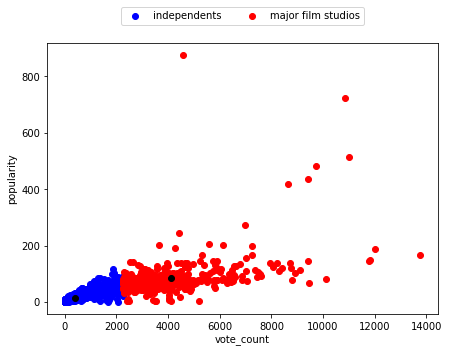

In [22]:
# Let's see the clusters
plot_graph(vote_count, popularity)

This implies that more movies produced by major film studios are more popular and had more vote counts unlike the movies produced by the independents.

## Clustering between Major film studios and Independents with respect to Vote average and Movie popularity

In [23]:
# Calling the function to obtain the centroids
centre(vote_average, popularity)

10.818681499885637
8.10948493887473
5.4444956131138715
4.267406932255652
3.097562805357102
2.3554151108478196
1.711465888306778
1.2339121615295578
1.0409593406944246
1.076974954334113
0.9349891816655207
1.2317705836313708
1.5661990054208133
1.0743017220947975
0.740990035434244
0.8267661765920584
0.8624553338649621
0.5579010935723137
0.7325706074743863
0.8286686935740226
0.9366821689916813
0.8871737168272649
0.5450090932179155
0.27368251892059536
0.0


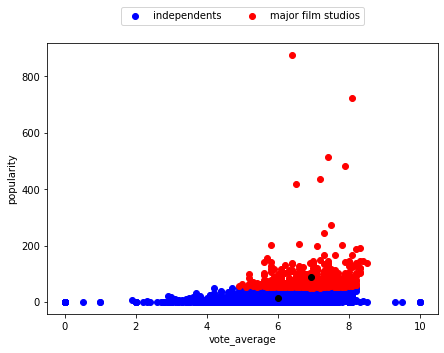

In [45]:
# Let's see the clusters
plot_graph(vote_average, popularity)

This implies that some of movies produced by the independents had a vote average greater than 9 unlike the popular movies produced by the major film studios. It also implies that popular movies produced by the major film studios had a vote average with a range of nothing less than 4 and greater than 9.

## Clustering between Major film studios and Independents with respect to the Weighted rating and Movie popularity

In [25]:
# Calling the function to obtain the centroids
centre(weighted_rating, popularity)

-8.508078270811616
-7.331421641237248
-6.031495705786159
-5.451997680205822
-3.8131714544824007
-1.7172735778122208
-1.4536173883584835
-0.7068900581929904
-0.5908958086129772
-0.485020935222118
-0.2881906568459973
-0.3820715080243504
-0.1890089257935621
-0.18779766989548197
-0.1862929354196181
-0.09188526521754703
0.0


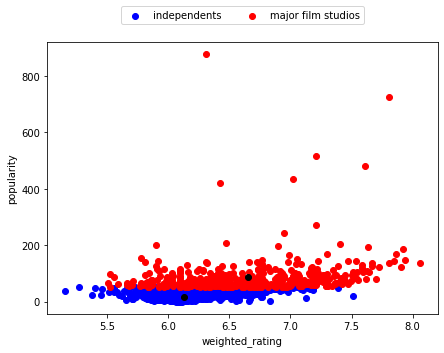

In [26]:
# Let's see the clusters
plot_graph(weighted_rating, popularity)

This implies that the movies produced by major film studios and independents have a decent number of movies with similar weighted ratings. Also, none of the movies produced by the independents have a weighted rating of 8 and above.

## Clustering between Major film studios and Independents, but this time I manually set the cluster labels instead of using centroids

Doing this to check if there is consistency between clusters obtained by centroids or if there is something more complicated going on.

In [27]:
movies_copy3 = movies_copy2.copy()

In [29]:
# Let's have a look at the film studios
movies_copy3['production_companies'].str.get_dummies(sep=', ').sum().sort_values(ascending = False)[:30]

Warner Bros.                              319
Universal Pictures                        311
Paramount Pictures                        285
Twentieth Century Fox Film Corporation    222
Columbia Pictures                         201
New Line Cinema                           165
Metro-Goldwyn-Mayer (MGM)                 122
Touchstone Pictures                       118
Walt Disney Pictures                      114
Relativity Media                          102
Columbia Pictures Corporation              96
Miramax Films                              94
Village Roadshow Pictures                  81
DreamWorks SKG                             79
Canal+                                     75
United Artists                             75
Regency Enterprises                        69
Fox Searchlight Pictures                   64
Dune Entertainment                         59
Lionsgate                                  56
TriStar Pictures                           55
The                               

In [30]:
# Let's pick the major film studios to manually obtain the clusters
big_studios = ['Warner Bros.', 'Universal Pictures', 'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Columbia Pictures', 'Walt Disney Pictures', 'Walt Disney', 'Columbia Pictures Corporation', 'Metro-Goldwyn-Mayer (MGM)']

In [31]:
# Getting a pattern
pattern = '|'.join(big_studios)
pattern

'Warner Bros.|Universal Pictures|Paramount Pictures|Twentieth Century Fox Film Corporation|Columbia Pictures|Walt Disney Pictures|Walt Disney|Columbia Pictures Corporation|Metro-Goldwyn-Mayer (MGM)'

In [32]:
# Obtaining a new column with True and False - if each row contains a major film studio or not
movies_copy3['new_cluster'] = movies_copy3.production_companies.str.contains(pattern)

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [33]:
# Changing the clusters to 1s and 2s - 1s for independents and 2s for major film studios
terms = [(movies_copy3['new_cluster'] == True), (movies_copy3['new_cluster'] == False)]
values = [2, 1]

movies_copy3['new_cluster'] = np.select(terms, values)

In [34]:
# Let's see the distribution
movies_copy3['new_cluster'].value_counts()

1    3246
2    1555
Name: new_cluster, dtype: int64

In [35]:
# Funtion to plot the scatter graph
def plot_graph(first_column, second_column):
  K = 2
  label = ['independents', 'major film studios']
  Centroids = movies_copy3.groupby(['new_cluster']).mean()[[second_column, first_column]]
  color = ['blue', 'red']
  for k in range(K):
      data = movies_copy3[movies_copy3['new_cluster'] == k+1]
      plt.scatter(data[first_column], data[second_column], c = color[k])
  fig = plt.gcf()
  fig.set_size_inches(7, 5)
  plt.scatter(Centroids[first_column], Centroids[second_column], c = 'black')
  plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.15), ncol = 2, labels = label)
  plt.xlabel(first_column)
  plt.ylabel(second_column)
  plt.show()

## Clustering between Major film studios and Independents with respect to the Vote count and Movie popularity

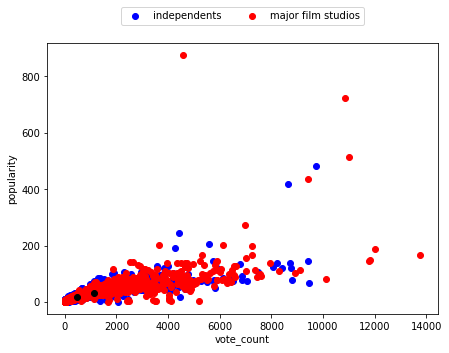

In [36]:
plot_graph(vote_count, popularity)

## Clustering between Major film studios and Independents with respect to the Vote average and Movie popularity

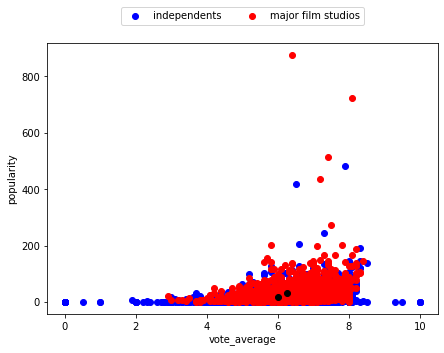

In [37]:
plot_graph(vote_average, popularity)

## Clustering between Major film studios and Independents with respect to the Weighted rating and Movie popularity

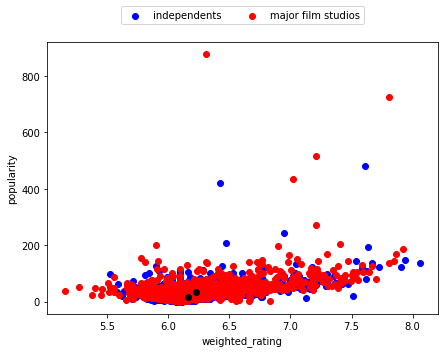

In [38]:
plot_graph(weighted_rating, popularity)

In conlusion, after manually differentiating the clusters for the major film studios and independents, we can see from the three graphs above that something much more complicated is going on unlike what we obtained after generating the clusters for the two columns from respective centroids.